# Разложение матриц градиентным методом

Цель задания: В ходе реализации [разложения Таккера](https://proceedings.neurips.cc/paper/2018/file/45a766fa266ea2ebeb6680fa139d2a3d-Paper.pdf) градиентным методом освоить pyTorch и реализовать подходы оптимизации параметров модели (в отсутствии готовых решений).

[Описание алгоритма канонического разложения](https://www.alexejgossmann.com/tensor_decomposition_tucker/) - само аналитическое разложение реализовывать не будем

In [1]:
import time
import torch
import numpy as np

from sklearn.metrics import mean_squared_error

torch.manual_seed(0)

## 1 Создадим 3х мерный тензор
Размер тензора не меньше 100 по каждой из размерностей.

Заполним случайными целыми числами в диапазоне от 0 до 9.

*Примечание*: разложение будет корректно работать со случайным тензором, только если изначально создавать случайные ядро и матрицы, а потом по ним формировать тензор. Работаем с типом *torch.Tensor.double*.

In [2]:
# Создадим тензор: размер тензора и r задаётся
def get_tensor(size=(100,200,150), r=10):
  # data - тензор с заданной размерностью
  # U - список матриц
  # G - ядро разложения
  core_shape = (10, 10, 10)
  G = torch.rand(core_shape, dtype=torch.double)

  U = []
  for mode_size, core_dim in zip(size, core_shape):
    factor_matrix = torch.rand((mode_size, core_dim), dtype=torch.double)
    U.append(factor_matrix)

  data = G.clone()
  for mode, factor_matrix in enumerate(U):
    data = torch.tensordot(data, factor_matrix, dims=([0], [1]))

  data = data.round().clamp(0, r-1)

  data = data.to(torch.double)

  return data, U, G

Сгенерируем тензор и добавим к нему случайный шум с размерностью *1e-2*

In [3]:
size = (100, 200, 300)
core_shape = (10, 10, 10)
r = 10

In [4]:


data, U, G = get_tensor(size, r)
data.shape, [u.shape for u in U], G.shape

(torch.Size([100, 200, 300]),
 [torch.Size([100, 10]), torch.Size([200, 10]), torch.Size([300, 10])],
 torch.Size([10, 10, 10]))

In [5]:
noise = torch.normal(mean=0.0, std=1e-2, size=data.size(), dtype=torch.double)
data += noise

Почему задача не имеет смысла для полностью случайного тензора и зачем добавлять шум?

*Ответ*: Разложение Такера нацелено на выделение паттернов в данных, и, благодаря этому, более компактному их представлению. В случае случайных же данных такое разложение не будет нести никакого смысла. Добавление шума важно для симмуляции реальных даных, которые зачастую зашумлены. В таком случае разложение Такера будет нацелено на выделение исходной внутреней структурой и исключении шума.


## 2 Реализуем метод для восстановления тензора по разложению

In [6]:
# Функция, восстанавливающая тензор по ядру и матрицам
def repair_tensor(G_, U):
  # data - восстановленный тензор из матриц и ядра
  # U - список матриц
  # G_ - ядро разложения

  data = G_.clone()
  for mode, factor_matrix in enumerate(U):
    data = torch.tensordot(data, factor_matrix, dims=([0], [1]))
  data = data.to(torch.double)

  return data

In [7]:
G = torch.rand(core_shape, dtype=torch.double)

U = []
for mode_size, core_dim in zip(size, core_shape):
  factor_matrix = torch.rand((mode_size, core_dim), dtype=torch.double)
  U.append(factor_matrix)

data = repair_tensor(G, U)
data.shape

torch.Size([100, 200, 300])

## 3 Сделаем разложение библиотечным методом

In [ ]:
# ! pip3 install tensorly

In [8]:
import tensorly as tl
from tensorly.decomposition import tucker

In [9]:
def lib_decompose(data):
  tensor = tl.tensor(data.numpy())

  core, factors = tucker(tensor, rank=core_shape)

  core = torch.tensor(core, dtype=torch.double)
  factors = [torch.tensor(factor, dtype=torch.double) for factor in factors]

  return core, factors

In [10]:
data, _, _ = get_tensor(size, r)

core, factors = lib_decompose(data)

rep_tensor = repair_tensor(core, factors)

In [11]:
mse = (data - rep_tensor).pow(2).sum() / data.numel()
print(f"Среднеквадратичная ошибка (MSE): {mse}")

Среднеквадратичная ошибка (MSE): 2.865153410053281e-28


In [12]:
# Библиотечный MSE
def loss_eval(tensor1, tensor2):
  tensor1_flat = tensor1.flatten()
  tensor2_flat = tensor2.flatten()

  mse = mean_squared_error(tensor1_flat.numpy(), tensor2_flat.numpy())

  return mse

In [13]:
mse = loss_eval(data, rep_tensor)
print(f"Среднеквадратичная ошибка (MSE): {mse}")

Среднеквадратичная ошибка (MSE): 2.865153410053281e-28


## 4 Реализуем разложение градиентным методом

### 4.1 Реализуем *optimizer*
Можно взять из исходников *PyTorch* и отнаследоваться от *torch.optim.optimizer*.
Используем квадратичный *Loss*.

In [14]:
import torch
from torch.optim.optimizer import Optimizer


class Opt(Optimizer):

  def __init__(self, params, lr=1e-3):

    defaults = {'lr': lr}
    super().__init__(params, defaults)

  def step(self):

    for group in self.param_groups:
      lr = group['lr']
      for param in group['params']:
        if param.grad is None:
            continue

        param.data -= lr * param.grad.data

### 4.2 Реализуем цикл оптимизации параметров

*Примечание*: параметры лучше оптимизировать сразу на GPU

In [29]:
lr=5e-2
num_iterations=30

losses = []

def sgd_decompose(data):

  factors = []
  for mode_size, core_dim in zip(size, core_shape):
    factors.append(torch.rand((mode_size, core_dim), requires_grad=True))

  core = torch.rand(core_shape, requires_grad=True)


  optimizer = Opt([core] + factors, lr=lr)


  for _ in range(num_iterations):
    rep_tensor = repair_tensor(core, factors)
    loss = (data - rep_tensor).pow(2).sum() / data.numel()

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    losses.append(loss.item())

    # if iteration % 10 == 0:
    #     print(f"Iteration {iteration}, Loss: {loss.item()}")

  return loss

In [30]:
data, _, _ = get_tensor(size, r)

loss = sgd_decompose(data)
print(f"Среднеквадратичная ошибка (MSE): {loss}")

Среднеквадратичная ошибка (MSE): 1.0468283176657915


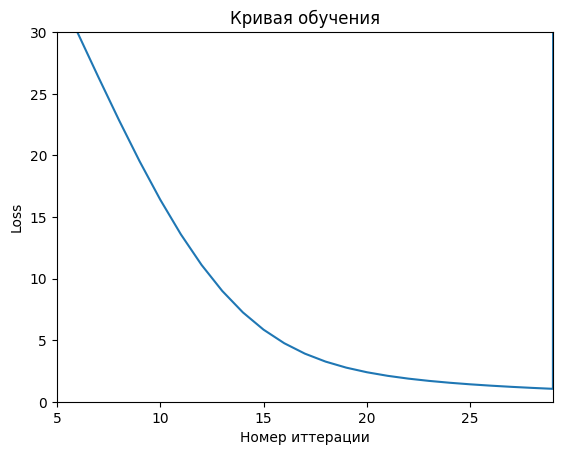

In [37]:
from matplotlib import pyplot as plt

plt.title("Кривая обучения")
plt.xlabel("Номер иттерации")
plt.ylabel("Loss")
plt.plot(losses)
plt.ylim(0,30)
plt.xlim(5,29)
plt.show()

## 5 Сравним скорости работы и ошибки восстановления методом из пакета и реализованного градиентного

In [34]:
lib_times = []
sgd_times = []
lib_mses = []
sgd_mses = []

for i in range(10):
  data, _, _ = get_tensor(size, r)

  start = time.time()
  lib_core, lib_factors = lib_decompose(data)
  lib_rep_tensor = repair_tensor(lib_core, lib_factors)
  lib_mse = (data - rep_tensor).pow(2).sum() / data.numel()
  end = time.time()

  lib_times.append(end - start)
  lib_mses.append(lib_mse)


  start = time.time()
  sgd_mse = sgd_decompose(data)
  end = time.time()

  sgd_times.append(end - start)
  sgd_mses.append(sgd_mse)



In [35]:
lib_mses = [elem.detach().numpy() for elem in lib_mses]
sgd_mses = [elem.detach().numpy() for elem in sgd_mses]

print(f'Библиотечный метод:')
print(f'Среднее время: {np.mean(lib_times)}')
print(f'Средняя ошибка: {np.mean(lib_mses)}')
print()
print(f'Градиентный метод:')
print(f'Среднее время: {np.mean(sgd_times)}')
print(f'Средняя ошибка: {np.mean(sgd_mses)}')

Библиотечный метод:
Среднее время: 0.8854606628417969
Средняя ошибка: 1.058333333333306e-05

Градиентный метод:
Среднее время: 0.5566077709197998
Средняя ошибка: 1.1303509745871005


Вывод: библиотечный метод однозначно делает более точное разложение, однако, поигравшись с гипермараметрами градиентного метода, можно получить выиграш по времени работы алгоритма. При оптимальном подборе гиперметров можно достичь достаточно хорошего лосса градиентным методом (порядка 1). Для справедливой оценки, какое значение потерь является хорошим, а какое плохим, мы должны учесть специфику нашей задачи (такие как, числа в матрице от 0 до 9, размерность матрица 3). Для таких данных и используемого метода оценки (MSE) получим допустимый разборс лосса от 0 до 81. Т.к. размерности 3, то занчение лосса 27 будет соответствовать полному несоответствию таргета и посчитанного матрицы (результат алгоритма: абсолютно случайная матрица). Значит с нашим лоссом порядка 1 мы действительно получили хороший результат. Что касается выбора оптимальных гиперпараметров, то это довольно тонкая вещь, мы здесь подбирали шаг обучения и количество иттераций.